## Microtask 2 ##
Produce a chart showing the distribution of time-to-close (using the corresponding field in the GrimoireLab enriched index for GitHub issues) for issues already closed, and opened during the last six months.

In [2]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q, A, aggs
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

**Step1**: Instantiate the Elasticsearch client

In [3]:
es_client = Elasticsearch('http://localhost:9200')

**Step2**: Use the `p2o.py` script to fetch the github data for perceval repository and store the raw records in `github_raw` index, and the enriched data in the `github` index

In [4]:
%%bash
p2o.py --enrich --index github_raw --index-enrich github -e http://localhost:9200 \
--no_inc --debug github grimoirelab perceval -t '47fb3a29d189e294e3fdc83ecfffb13f737fb684' --sleep-for-rate

2018-03-07 22:23:21,105 Debug mode activated
2018-03-07 22:23:22,218 Rate limit: 5000
2018-03-07 22:23:22,218 Rate limit reset: 1520445201
2018-03-07 22:23:22,274 Feeding Ocean from github (https://github.com/grimoirelab/perceval)
2018-03-07 22:23:22,282 Found version of ES instance at http://localhost:9200: 6.
2018-03-07 22:23:22,357 Created index http://localhost:9200/github_raw
2018-03-07 22:23:22,384 Creating OceanConf index http://localhost:9200/conf
2018-03-07 22:23:22,385 http://localhost:9200/github_raw/_search 
        { "size": 0, 
                "query" : {
                    "term" : { "origin" : "https://github.com/grimoirelab/perceval"  }
                 },
              
            "aggs": {
                "1": {
                  "max": {
                    "field": "metadata__updated_on"
                  }
                }
            }
        
        } 
2018-03-07 22:23:22,393 Incremental from: None
2018-03-07 22:23:22,393 Get GitHub paginated items from htt

**Step3**: Create a DSL search object to query the enriched `github` index created earlier. The search query will fetch objects which:
1. Are issues (have `item_type` field set to the value *'issue'*)
2. Are in a closed state (have `state` field set to the value *'closed'*)
3. Have been created in the past 6 months (have the `created_at` field set to a value which falls in the last 6 months) <br>
Additionally we only fetch the `id` and `time_to_close` days fields instead of the complete documents to avoid transferring redundant data

In [64]:
search = Search(using=es_client, index='github')\
         .source(['id', 'time_to_close_days'])\
         .filter('term', item_type='issue')\
         .filter('term', state='closed')\
         .filter('range', created_at={'gte': 'now-6M'})
results = search.scan()

**Step4**: From the search results, create a dataframe holding the `id` and `time_to_close` value for each issue

In [65]:
issues = pd.DataFrame.from_records([ 
            {
                'id' : result['id'],
                'time_to_close' : result['time_to_close_days']
            } 
            for result in results
        ])

**Step5**: Create a histogram plotting the `time_to_close` for the issues created in the past six months

Text(0,0.5,'Count of issues')

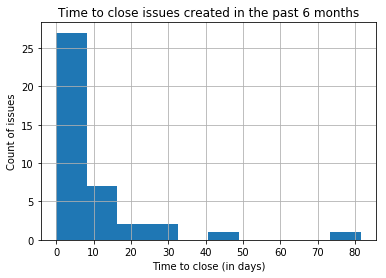

In [74]:
ttc_plot = issues['time_to_close'].hist()
ttc_plot.set_title('Time to close issues created in the past 6 months')
ttc_plot.set_xlabel('Time to close (in days)')
ttc_plot.set_ylabel('Count of issues')